In [153]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool, set_tempdir
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
set_tempdir(project_path)
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
45566,chr16,223472,223709,unfragmented.filtered.rvs_peak_9673,22769,582.79260,2284.49341,2276.95703,778.0,15,.,Unannotated,-,.,Long RNA,0.0,0.0,Antisense
45568,chr16,230338,230554,unfragmented.filtered.rvs_peak_9676,19214,485.39862,1928.82178,1921.49854,694.0,12,.,Unannotated,-,NCBP2,RBP,0.0,0.0,Antisense
45567,chr16,227335,227447,unfragmented.filtered.rvs_peak_9675,19838,528.80157,1991.33948,1983.87415,671.0,12,.,Unannotated,-,.,Long RNA,0.0,0.0,Antisense
0,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5097,22292,530.63562,2236.70190,2229.25269,537.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense
1,chr16,24228399,24228506,unfragmented.filtered.fwd_peak_10504,16141,415.71204,1621.19678,1614.14233,425.0,14,GA-rich,Repeats,+,.,Unannotated,0.0,0.0,Sense


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


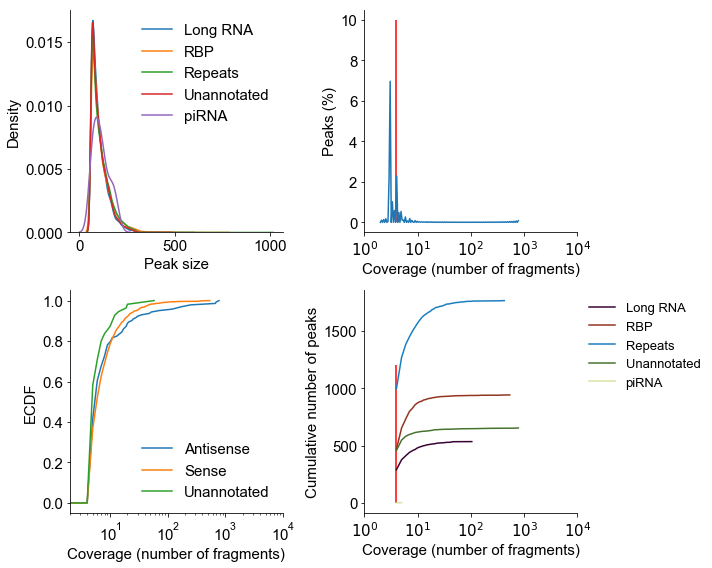

In [155]:
fig = plt.figure(figsize=(10,8))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


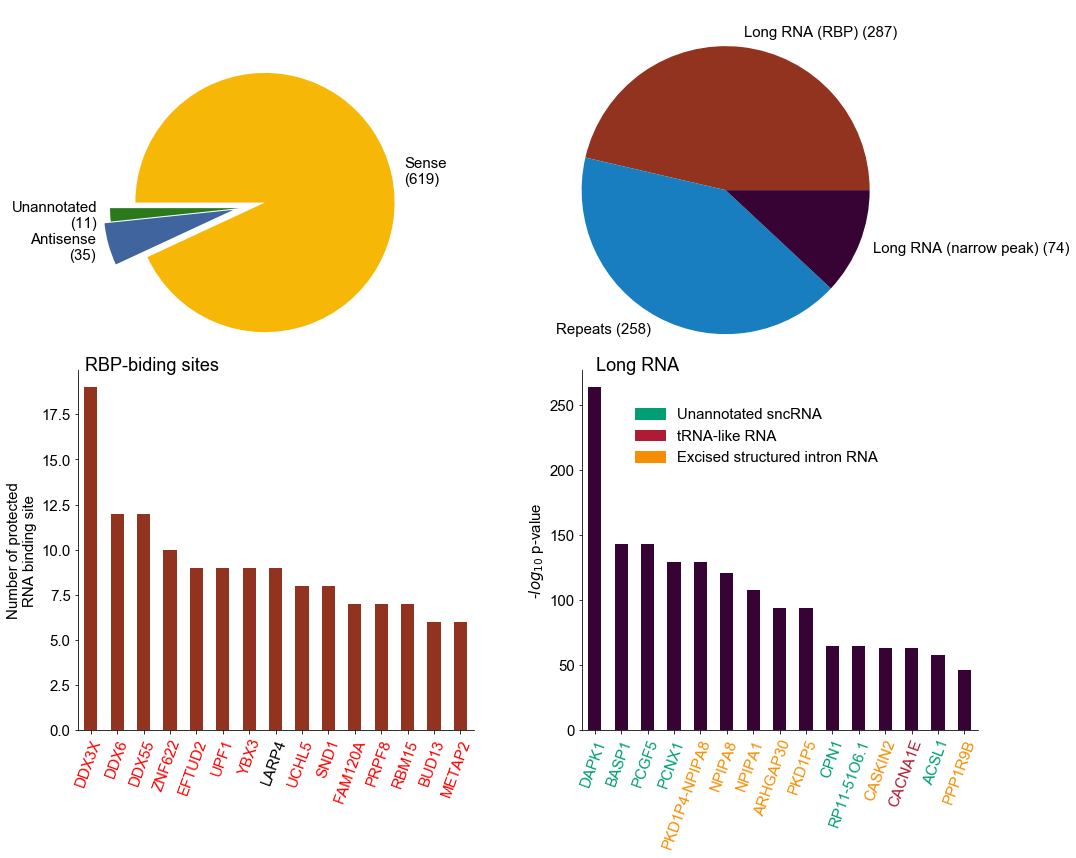

In [181]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.55, 0.5, 0.5, 0.5])
#rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
#long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.55, 0.5])
long_ax = fig.add_axes([0.6, 0, 0.55, 0.5])

#misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
#plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
fig.text(-0.09,0.5, 'RBP-biding sites', fontsize=18)
fig.text(0.62,0.5, 'Long RNA', fontsize=18)
#fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [26]:
ec = ecoli_mapper()
a = ec.ecoli_map('chr9',9029412,90294292)
a

0.0002130469981677958

In [44]:
ec = ecoli_mapper()
peak_df\
    .query('sample_count >= %i & sense_gtype=="Long RNA"' %(sample_cutoff))\
    .nlargest(20,'log10q')\
    .reset_index(drop=True)\
    .assign(is_ecoli = lambda d: list(map(ec.ecoli_map,d.chrom, d.start, d.end))) \
    .assign(seq = lambda d:  list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(mt = lambda d: d.seq.map(is_mt))\
    .filter(['chrom','start','end','peakname','strand','sense_gname','is_ecoli','seq','mt'])

,chrom,start,end,peakname,strand,sense_gname,is_ecoli,seq,mt
0,chr9,90294212,90294292,unfragmented.filtered.fwd_peak_29183,+,DAPK1,0.0,GGCAAGACAGGTTTTGTGGGTTTGTGGGAACCCACAAAGCAGGTTA...,not_MT
1,chr10,92933895,92933968,unfragmented.filtered.fwd_peak_3804,+,PCGF5,0.0,CTTGGGCCACTGTAGGTTGGATATGAAGTGGCATGAAGGATTCAGT...,not_MT
2,chr5,17249702,17249764,unfragmented.filtered.fwd_peak_22475,+,BASP1,0.0,TTGAGTTTGAGATCTCAGAAAATAAAATAGTGCCACCAAAATACAA...,not_MT
3,chr14,71389030,71389208,unfragmented.filtered.fwd_peak_8633,+,PCNX1,0.0,TCTTTAATAGGTATTAGACAAAAACATGAATTTTTTTCTTGCAAAC...,not_MT
4,chr16,16468913,16469003,unfragmented.filtered.fwd_peak_10387,+,RP11-958N24.2,0.0,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT
5,chr16,18430617,18430707,unfragmented.filtered.rvs_peak_9968,-,RP11-1212A22.1,0.0,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT
6,chr16,15027133,15027223,unfragmented.filtered.fwd_peak_10367,+,RP11-958N24.1,0.0,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT
7,chr14,71461625,71461751,unfragmented.filtered.fwd_peak_8635,+,PCNX1,0.0,TGTATCAAACTTAGGCCTAATATCCTTTGAGAAATTACTAGTTTCC...,not_MT
8,chr1,161022152,161022229,unfragmented.filtered.rvs_peak_1748,-,ARHGAP30,0.0,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,not_MT
9,chr16,18470719,18470809,unfragmented.filtered.rvs_peak_9969,-,RP11-1212A22.4,0.0,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT


# Intron #

In [98]:
from miRNA_tools import miRNA_test, test_mirtron, fold_intron
mitest = miRNA_test()


full_peak = pd.read_table(peak_path + '/unfragmented.unfiltered.tsv')\
    .query('sample_count >= %i' %sample_cutoff)
columns = full_peak.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(full_peak)\
    .intersect('/stor/work/Lambowitz/ref/hg19_ref/genes/introns.bed.gz', 
               f= 0.95,F=0.95,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

(112, 21)

In [100]:
confirmed_intron = intron_df \
    .query('sample_count >= 5' )\
    .filter(['chrom','start','end','intron_start','intron_end',
             'strand','peakname','sense_gname','sample_count','pileup','seq'])\
    .drop_duplicates()\
    .reset_index(drop=True) \
    .assign(size = lambda d: d.end - d.start) \
    .assign(miRNA = lambda d: list(map(mitest.test, d.chrom, d.start, d.end))) 
confirmed_intron.head()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA
0,chr19,11333581,11333668,11333581,11333668,-,unfragmented.unfiltered.rvs_peak_12848,EFTUD2,15,390.0,87,No
1,chr22,50356513,50356587,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19194,MIR6821,14,122.0,74,Yes
2,chr17,39913788,39913885,39913788,39913885,-,unfragmented.unfiltered.rvs_peak_11234,XPO5,15,46.0,97,No
3,chr16,16468913,16469003,16468913,16469003,+,unfragmented.unfiltered.fwd_peak_10561,RP11-958N24.2,13,45.0,90,No
4,chr16,18430617,18430707,18430617,18430707,-,unfragmented.unfiltered.rvs_peak_9830,RP11-1212A22.1,15,44.0,90,No


In [101]:
confirmed_intron.query('miRNA=="Yes"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA
1,chr22,50356513,50356587,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19194,MIR6821,14,122.0,74,Yes
12,chr2,220088744,220088827,220088744,220088827,-,unfragmented.unfiltered.rvs_peak_15684,AC068946.1,12,28.0,83,Yes
13,chr6,31924615,31924717,31924615,31924717,-,unfragmented.unfiltered.rvs_peak_22728,MIR1236,12,23.0,102,Yes
17,chr6,31323000,31323093,31323000,31323093,-,unfragmented.unfiltered.rvs_peak_22707,MIR6891,11,19.0,93,Yes
18,chr16,28855177,28855270,28855176,28855270,-,unfragmented.unfiltered.rvs_peak_9967,MIR4721,10,23.0,93,Yes
30,chr16,2140195,2140285,2140195,2140285,-,unfragmented.unfiltered.rvs_peak_9609,MIR1225,5,10.0,90,Yes


In [102]:
confirmed_intron

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA
0,chr19,11333581,11333668,11333581,11333668,-,unfragmented.unfiltered.rvs_peak_12848,EFTUD2,15,390.0,87,No
1,chr22,50356513,50356587,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19194,MIR6821,14,122.0,74,Yes
2,chr17,39913788,39913885,39913788,39913885,-,unfragmented.unfiltered.rvs_peak_11234,XPO5,15,46.0,97,No
3,chr16,16468913,16469003,16468913,16469003,+,unfragmented.unfiltered.fwd_peak_10561,RP11-958N24.2,13,45.0,90,No
4,chr16,18430617,18430707,18430617,18430707,-,unfragmented.unfiltered.rvs_peak_9830,RP11-1212A22.1,15,44.0,90,No
5,chr16,15027133,15027223,15027133,15027223,+,unfragmented.unfiltered.fwd_peak_10541,RP11-958N24.1,13,40.0,90,No
6,chr16,2149771,2149861,2149771,2149861,-,unfragmented.unfiltered.rvs_peak_9610,EFTUD2,11,35.0,90,No
7,chr16,16425620,16425710,16425620,16425710,+,unfragmented.unfiltered.fwd_peak_10559,PKD1P1,12,35.0,90,No
8,chr1,161022153,161022229,161022153,161022229,-,unfragmented.unfiltered.rvs_peak_1747,ARHGAP30,13,31.0,76,No
9,chr16,18470719,18470809,18470719,18470809,-,unfragmented.unfiltered.rvs_peak_9831,RP11-1212A22.4,12,34.0,90,No


In [108]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []       

intron_df = confirmed_intron.query('pileup >=5') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.intron_start, d.intron_end, d.strand))) \
    .assign(seq = lambda d: d.seq.str.upper())\
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA,seq,dinucleotide
0,chr19,11333581,11333668,11333581,11333668,-,unfragmented.unfiltered.rvs_peak_12848,EFTUD2,15,390.0,87,No,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:AG
1,chr22,50356513,50356587,50356513,50356587,+,unfragmented.unfiltered.fwd_peak_19194,MIR6821,14,122.0,74,Yes,GTGCGTGGTGGCTCGAGGCGGGGGTGGGGGCCTCGCCCTGCTTGGG...,GT:AG
2,chr17,39913788,39913885,39913788,39913885,-,unfragmented.unfiltered.rvs_peak_11234,XPO5,15,46.0,97,No,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:AG
3,chr16,16468913,16469003,16468913,16469003,+,unfragmented.unfiltered.fwd_peak_10561,RP11-958N24.2,13,45.0,90,No,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG
4,chr16,18430617,18430707,18430617,18430707,-,unfragmented.unfiltered.rvs_peak_9830,RP11-1212A22.1,15,44.0,90,No,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:AG


In [111]:
mirtron = intron_df\
    .groupby('seq', as_index=False)\
    .apply(lambda d: d.nlargest(1,'pileup'))\
    .reset_index(drop=True) \
    .assign(fold = lambda d: d.seq.map(fold_intron))\
    .assign(mirtron_type = lambda d: d.fold.map(test_mirtron))
mirtron

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA,seq,dinucleotide,fold,mirtron_type
0,chrX,153670775,153670865,153670775,153670866,+,unfragmented.unfiltered.fwd_peak_31423,PRPF8,6,10.0,90,No,GTAAGCAGCTCGTCCCAGCCCTGGGCTCCTGGCTGCCCGCCCAGGA...,GT:AG,(.((((((((.(.((((((...((((........))))(((((((....,3-trim
1,chr6,31323000,31323093,31323000,31323093,-,unfragmented.unfiltered.rvs_peak_22707,MIR6891,11,19.0,93,Yes,GTAAGGAGGGGGATGAGGGGTCATATCTCTTCTCAGGGAAAGCAGG...,GT:AG,..((((((((((((((((((((....((((.((.((((...((......,Both trim
2,chr16,718411,718487,718411,718487,+,unfragmented.unfiltered.fwd_peak_10277,XPO5,6,13.0,76,No,GTAAGGGGCACGCCCGCCGCGGGGGTGGGAGCGGGCCCAGCCGGGG...,GT:AG,(((((((((...((((((.....)))))).(((.((...((((((....,3-trim
3,chr1,161022153,161022229,161022153,161022229,-,unfragmented.unfiltered.rvs_peak_1747,ARHGAP30,13,31.0,76,No,GTAAGTCTGGGGAGATGGGGGGAGCTCTGCTGAGGGTGCACAAGGC...,GT:AG,(((((.(.(((((..((...((((((......(((((.......))...,3-trim
4,chr1,54717368,54717466,54717365,54717466,-,unfragmented.unfiltered.rvs_peak_917,RBM22,6,8.0,98,No,GTAGAGAGGGCAGGGTGGGCCTAGGGTGGCTGGGGATGCCAGGAGG...,GT:AG,(((((((((...(((((.((...(((((((.((((.((...(((((...,3-trim
5,chr19,11333581,11333668,11333581,11333668,-,unfragmented.unfiltered.rvs_peak_12848,EFTUD2,15,390.0,87,No,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:AG,(((((((.(((.((((.((.(((((((((.((.(.(........)....,3-trim
6,chr17,73500561,73500652,73500561,73500652,-,unfragmented.unfiltered.rvs_peak_11668,CASKIN2,12,23.0,91,No,GTAGGATGATGGGGTCACGGACCAGGTCAGGGCTCACTCCCCACTG...,GT:AG,(.((((.(((((((.((.(((((((.(((((((............)...,3-trim
7,chr16,67685748,67685821,67685748,67685823,+,unfragmented.unfiltered.fwd_peak_11156,(GGCTG)n,5,5.0,73,No,GTAGGCTGGATGGGGCTGGGCTGGGCAAGGCTGAGCAAAGCCAGCC...,GT:AG,...(((.(((.(((((.(((.(((((..((((......)))).)))...,Both trim
8,chr5,180048007,180048105,180048007,180048105,-,unfragmented.unfiltered.rvs_peak_22256,FLT4,5,8.0,98,No,GTAGGGAGGGTGGCCCTGGCGAAGGGCAGGTCCGGAGGCCCGCGAG...,GT:AG,((((((..(((((((((.....))))).((..((..((((.....)...,3-trim
9,chr19,40913938,40914064,40913938,40914064,-,unfragmented.unfiltered.rvs_peak_13289,PRX,5,6.0,126,No,GTGAGAGGACAGCTGGGGTGGGGGCCCTTCTCCCCTTCTAATACCC...,GT:AG,(((.(((((((((.((((((((((((.......................,3-trim


In [112]:
mirtron.groupby('mirtron_type').count()

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA,seq,dinucleotide,fold
mirtron_type,,,,,,,,,,,,,,,
3-trim,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
5-trim,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Both trim,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Conventional,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [106]:
intron_df.query('dinucleotide != "GT:AG"')

,chrom,start,end,intron_start,intron_end,strand,peakname,sense_gname,sample_count,pileup,size,miRNA,seq,dinucleotide
43,chr16,67685748,67685821,67685748,67685823,+,unfragmented.unfiltered.fwd_peak_11156,(GGCTG)n,5,5.0,73,No,gtaggctggatggggctgggctgggcaaggctgagcAAAGCCAGCC...,gt:AG


In [79]:
tablename = figure_path + '/intron_table.csv'
confirmed_intron \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [ ]:
seqfile = peak_path  + '/unfragmented.intron.fa'
with open(seqfile, 'w')  as fa:
    for i, row in intron_df\
            .query('pileup >= 5 & sample_count >= 5' )\
            .filter(['seq'])\
            .drop_duplicates()\
            .iterrows():
        print('>%s\n%s' %('peak'+str(i), row['seq']), file = fa)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [ ]:
','.join(rbp_df.head(15).index)

In [ ]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [ ]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

In [ ]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
    rbp_count = defaultdict(int)
    for i, row in peaks.query('pileup >= %i & sample_count >= %i' %(pileup_cutoff, sample_cutoff)).iterrows():
        added = set()
        for btype, bp in zip(row['sense_gtype'].split(','),
                        row['sense_gname'].split(',')):
            if btype == "RBP":
                if bp not in added:
                    rbp_count[bp] += 1
                    added.add(bp)

    rbp_df = pd.DataFrame\
        .from_dict(rbp_count, orient='index')\
        .sort_values(0, ascending=False)

In [ ]:
','.join(rbp_df.head(15).index)